In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam 
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg16 import VGG16

%matplotlib inline

In [5]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import calculate_auc, auc

### Data Generator

In [6]:
data_dir = './data/'

In [6]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=None, val_limit=None)
len(x_train), len(x_valid)

(10000, 10000)

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

## MODEL

In [ ]:
def build_arch_2_net():
    
    nasnet = NASNetLarge(weights='imagenet', include_top=False)
    inputs = Input((224, 224, 3))
    x = nasnet(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    
    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [9]:
model = build_arch_2_net()

In [ ]:
model.summary()

### Compile

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
optimizer = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'
# categorical_crossentropy
metrics = ['acc', auc]

In [15]:
model.compile(optimizer, loss, metrics)

W0519 22:30:35.652282 140425333194880 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0519 22:30:35.657427 140425333194880 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.

W0519 22:30:35.658812 140425333194880 deprecation.py:323] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:179: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0519 22:30:35.674

## Train the model

In [16]:
model_name = 'nasnet_model_bin_cross_arch_2_lr_0_001'

In [ ]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
train_params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)

# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

In [18]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

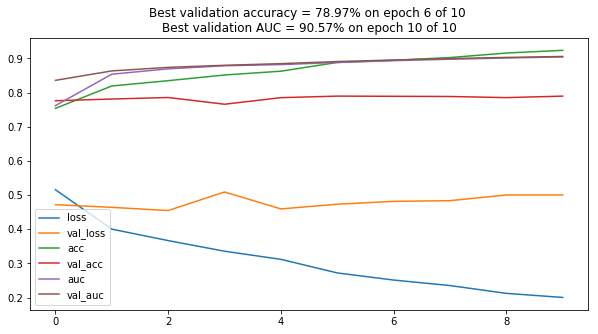


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


In [19]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)